<a href="https://colab.research.google.com/github/conglapgit45/Vanishing_Gradient_Handling_for_MLP/blob/main/Vanishing_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
# Check device and setup fixed random seed

device = torch.device ('cuda: 0' if torch.cuda.is_available()else 'cpu')
print(device)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

cpu


In [3]:
# Download Fashion MNIS dataset
train_dataset = FashionMNIST(
    './data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_dataset = FashionMNIST (
    './data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Split data to trainset and valset
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 512

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True )
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False )

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


# Base Model

In [ ]:
# Build MLP model
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3042, Train_Acc: 0.0998, Validation Loss: 2.3048, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3033, Train_Acc: 0.0979, Validation Loss: 2.3035, Val_Acc: 0.0895
EPOCH 3/100, Train_Loss: 2.3032, Train_Acc: 0.0984, Validation Loss: 2.3035, Val_Acc: 0.1022
EPOCH 4/100, Train_Loss: 2.3033, Train_Acc: 0.0998, Validation Loss: 2.3030, Val_Acc: 0.1022
EPOCH 5/100, Train_Loss: 2.3031, Train_Acc: 0.1005, Validation Loss: 2.3034, Val_Acc: 0.1012
EPOCH 6/100, Train_Loss: 2.3033, Train_Acc: 0.0992, Validation Loss: 2.3036, Val_Acc: 0.1000
EPOCH 7/100, Train_Loss: 2.3033, Train_Acc: 0.0999, Validation Loss: 2.3035, Val_Acc: 0.0937
EPOCH 8/100, Train_Loss: 2.3031, Train_Acc: 0.0999, Validation Loss: 2.3026, Val_Acc: 0.1018
EPOCH 9/100, Train_Loss: 2.3032, Train_Acc: 0.1001, Validation Loss: 2.3031, Val_Acc: 0.1020
EPOCH 10/100, Train_Loss: 2.3031, Train_Acc: 0.1012, Validation Loss: 2.3022, Val_Acc: 0.1097
EPOCH 11/100, Train_Loss: 2.3032, Train_Acc: 0.0993, Validation Loss:

KeyboardInterrupt: 

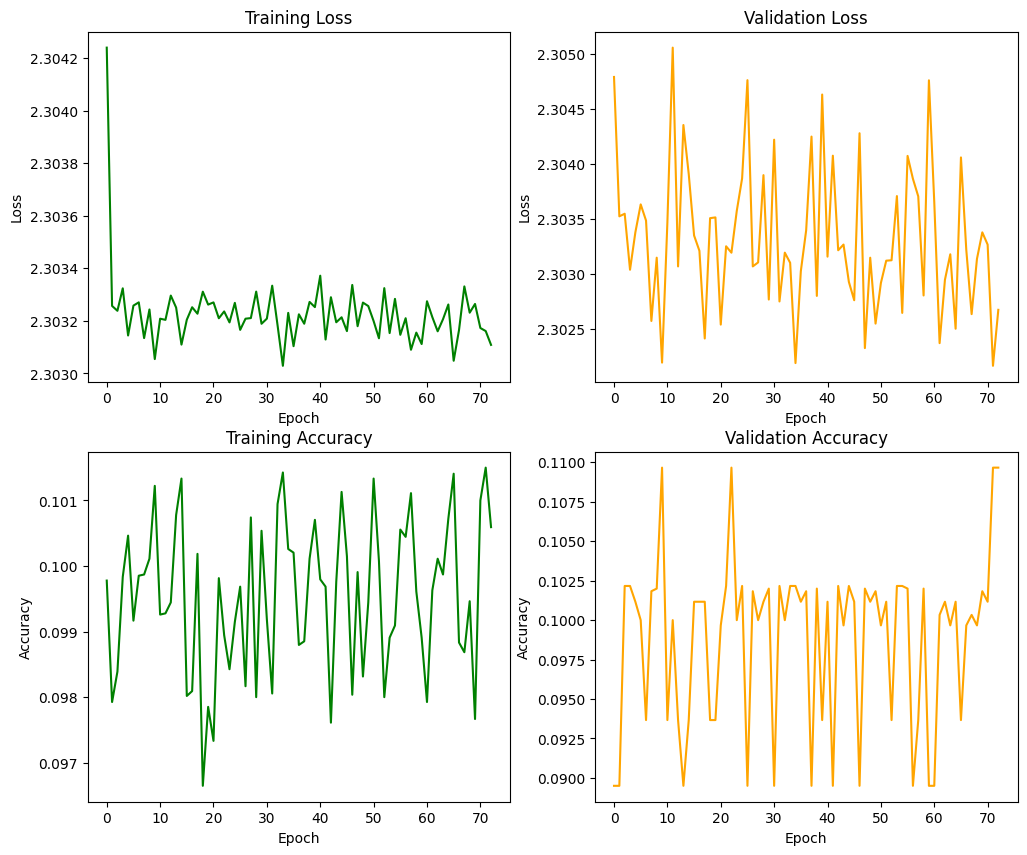

In [ ]:
# Visualize performance of base model
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
# Evaluate base model

test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1)==test_target).sum().item() / len(test_target)

print('Evaluation on test set: ')
print(f'Accuracy: {test_acc}')

Evaluation on test set: 
Accuracy: 0.1


# Handle Vanshing Gradient by Weight Increasing (mean = 0, std = 10)

In [ ]:
# Handle Vanshing Gradient by Weight Increasing (mean = 0, std = 10)

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 93.7354, Train_Acc: 0.1040, Validation Loss: 84.3887, Val_Acc: 0.0947
EPOCH 2/50, Train_Loss: 75.5062, Train_Acc: 0.1014, Validation Loss: 68.4233, Val_Acc: 0.1110
EPOCH 3/50, Train_Loss: 62.1925, Train_Acc: 0.1076, Validation Loss: 56.1697, Val_Acc: 0.1038
EPOCH 4/50, Train_Loss: 52.6470, Train_Acc: 0.1143, Validation Loss: 50.7879, Val_Acc: 0.1287
EPOCH 5/50, Train_Loss: 44.9723, Train_Acc: 0.1241, Validation Loss: 38.5502, Val_Acc: 0.1245
EPOCH 6/50, Train_Loss: 38.0738, Train_Acc: 0.1278, Validation Loss: 37.8666, Val_Acc: 0.1113
EPOCH 7/50, Train_Loss: 32.2795, Train_Acc: 0.1156, Validation Loss: 24.7512, Val_Acc: 0.1330
EPOCH 8/50, Train_Loss: 18.9152, Train_Acc: 0.1298, Validation Loss: 13.9186, Val_Acc: 0.1118
EPOCH 9/50, Train_Loss: 12.1639, Train_Acc: 0.1262, Validation Loss: 10.6165, Val_Acc: 0.1285
EPOCH 10/50, Train_Loss: 8.5563, Train_Acc: 0.1182, Validation Loss: 7.8997, Val_Acc: 0.1088
EPOCH 11/50, Train_Loss: 6.9135, Train_Acc: 0.1162, Validatio

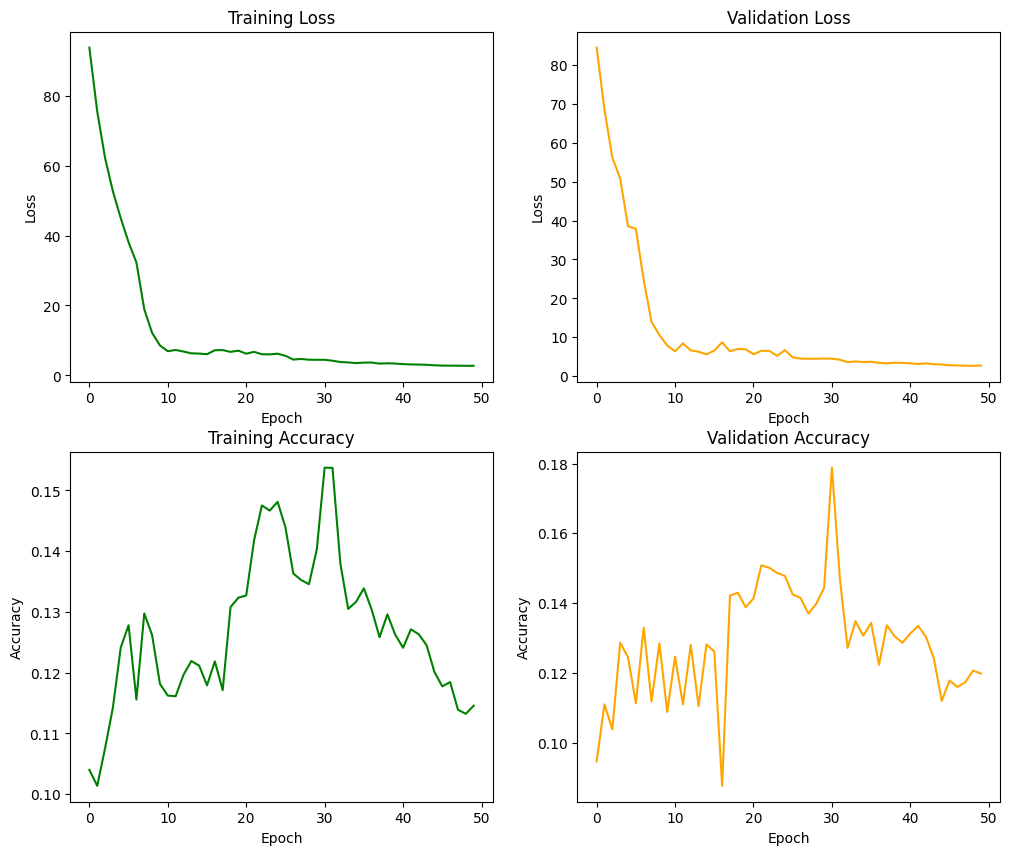

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanshing Gradient by Weight Increasing (mean = 0, std = 1)

In [ ]:
# Handle Vanshing Gradient by Weight Increasing (mean = 0, std = 1)

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 3.3275, Train_Acc: 0.1649, Validation Loss: 2.1123, Val_Acc: 0.2562
EPOCH 2/50, Train_Loss: 1.9734, Train_Acc: 0.3029, Validation Loss: 1.8191, Val_Acc: 0.3502
EPOCH 3/50, Train_Loss: 1.7506, Train_Acc: 0.3732, Validation Loss: 1.6515, Val_Acc: 0.4063
EPOCH 4/50, Train_Loss: 1.6117, Train_Acc: 0.4200, Validation Loss: 1.5398, Val_Acc: 0.4457
EPOCH 5/50, Train_Loss: 1.5114, Train_Acc: 0.4541, Validation Loss: 1.4547, Val_Acc: 0.4702
EPOCH 6/50, Train_Loss: 1.4348, Train_Acc: 0.4823, Validation Loss: 1.3882, Val_Acc: 0.4948
EPOCH 7/50, Train_Loss: 1.3718, Train_Acc: 0.5034, Validation Loss: 1.3331, Val_Acc: 0.5113
EPOCH 8/50, Train_Loss: 1.3189, Train_Acc: 0.5232, Validation Loss: 1.2877, Val_Acc: 0.5285
EPOCH 9/50, Train_Loss: 1.2749, Train_Acc: 0.5389, Validation Loss: 1.2477, Val_Acc: 0.5425
EPOCH 10/50, Train_Loss: 1.2369, Train_Acc: 0.5521, Validation Loss: 1.2140, Val_Acc: 0.5578
EPOCH 11/50, Train_Loss: 1.2035, Train_Acc: 0.5651, Validation Loss: 1.1817, Va

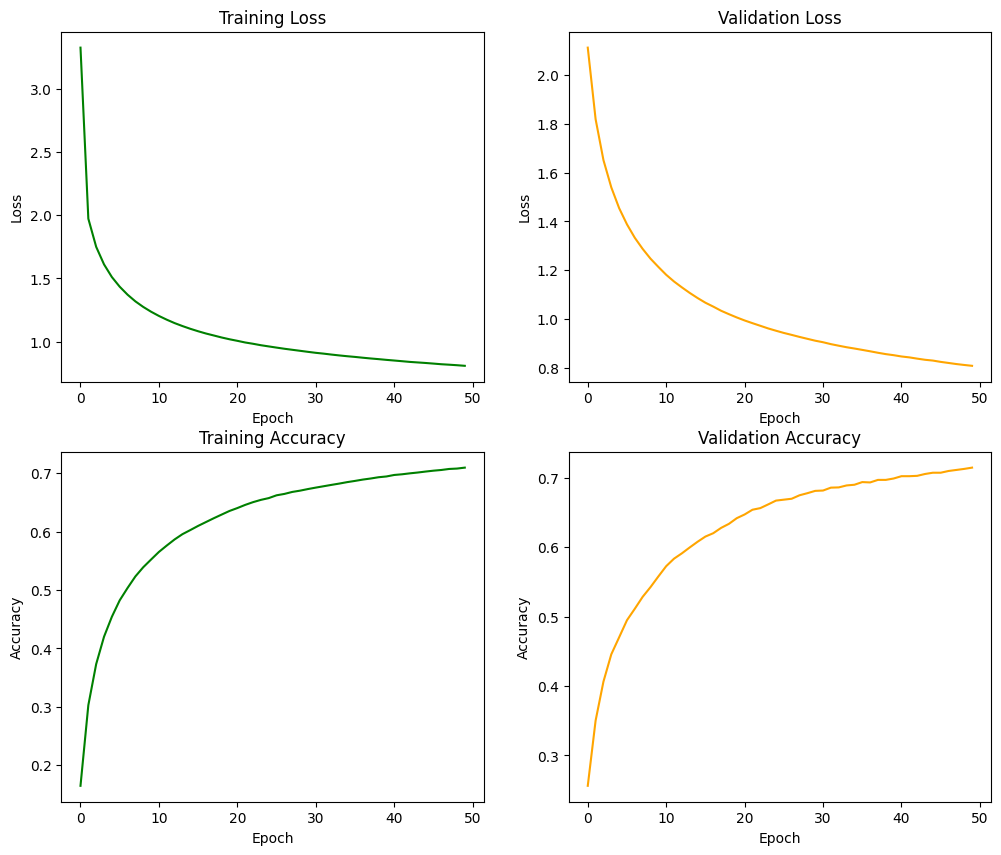

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Activation function change

In [ ]:
# Change activation function: Sigmoid --> ReLU

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 0.8044, Train_Acc: 0.7104, Validation Loss: 0.8045, Val_Acc: 0.7150
EPOCH 2/50, Train_Loss: 0.8005, Train_Acc: 0.7118, Validation Loss: 0.8021, Val_Acc: 0.7167
EPOCH 3/50, Train_Loss: 0.7970, Train_Acc: 0.7135, Validation Loss: 0.7980, Val_Acc: 0.7185
EPOCH 4/50, Train_Loss: 0.7933, Train_Acc: 0.7145, Validation Loss: 0.7949, Val_Acc: 0.7177
EPOCH 5/50, Train_Loss: 0.7898, Train_Acc: 0.7156, Validation Loss: 0.7913, Val_Acc: 0.7228
EPOCH 6/50, Train_Loss: 0.7853, Train_Acc: 0.7175, Validation Loss: 0.7882, Val_Acc: 0.7213
EPOCH 7/50, Train_Loss: 0.7828, Train_Acc: 0.7188, Validation Loss: 0.7846, Val_Acc: 0.7232
EPOCH 8/50, Train_Loss: 0.7793, Train_Acc: 0.7202, Validation Loss: 0.7822, Val_Acc: 0.7217
EPOCH 9/50, Train_Loss: 0.7754, Train_Acc: 0.7209, Validation Loss: 0.7784, Val_Acc: 0.7242
EPOCH 10/50, Train_Loss: 0.7724, Train_Acc: 0.7224, Validation Loss: 0.7761, Val_Acc: 0.7248
EPOCH 11/50, Train_Loss: 0.7694, Train_Acc: 0.7236, Validation Loss: 0.7732, Va

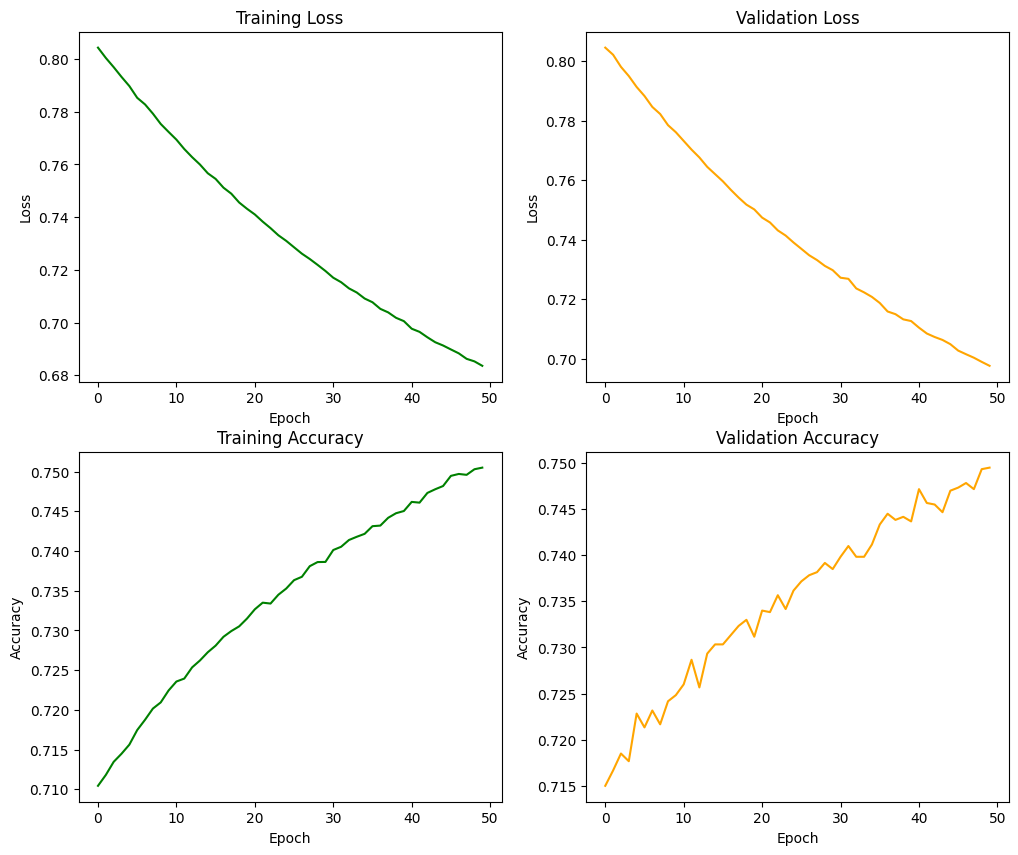

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Optimizer change

In [ ]:
# Change optimizer: SGD --> Adam

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 1.0833, Train_Acc: 0.6553, Validation Loss: 0.5813, Val_Acc: 0.7892
EPOCH 2/50, Train_Loss: 0.5340, Train_Acc: 0.8095, Validation Loss: 0.5548, Val_Acc: 0.8008
EPOCH 3/50, Train_Loss: 0.4880, Train_Acc: 0.8271, Validation Loss: 0.4958, Val_Acc: 0.8275
EPOCH 4/50, Train_Loss: 0.4464, Train_Acc: 0.8415, Validation Loss: 0.4832, Val_Acc: 0.8312
EPOCH 5/50, Train_Loss: 0.4181, Train_Acc: 0.8518, Validation Loss: 0.4431, Val_Acc: 0.8482
EPOCH 6/50, Train_Loss: 0.4010, Train_Acc: 0.8555, Validation Loss: 0.4430, Val_Acc: 0.8437
EPOCH 7/50, Train_Loss: 0.3855, Train_Acc: 0.8632, Validation Loss: 0.4153, Val_Acc: 0.8507
EPOCH 8/50, Train_Loss: 0.3685, Train_Acc: 0.8676, Validation Loss: 0.4323, Val_Acc: 0.8550
EPOCH 9/50, Train_Loss: 0.3615, Train_Acc: 0.8685, Validation Loss: 0.4016, Val_Acc: 0.8598
EPOCH 10/50, Train_Loss: 0.3528, Train_Acc: 0.8725, Validation Loss: 0.4039, Val_Acc: 0.8572
EPOCH 11/50, Train_Loss: 0.3473, Train_Acc: 0.8743, Validation Loss: 0.3994, Va

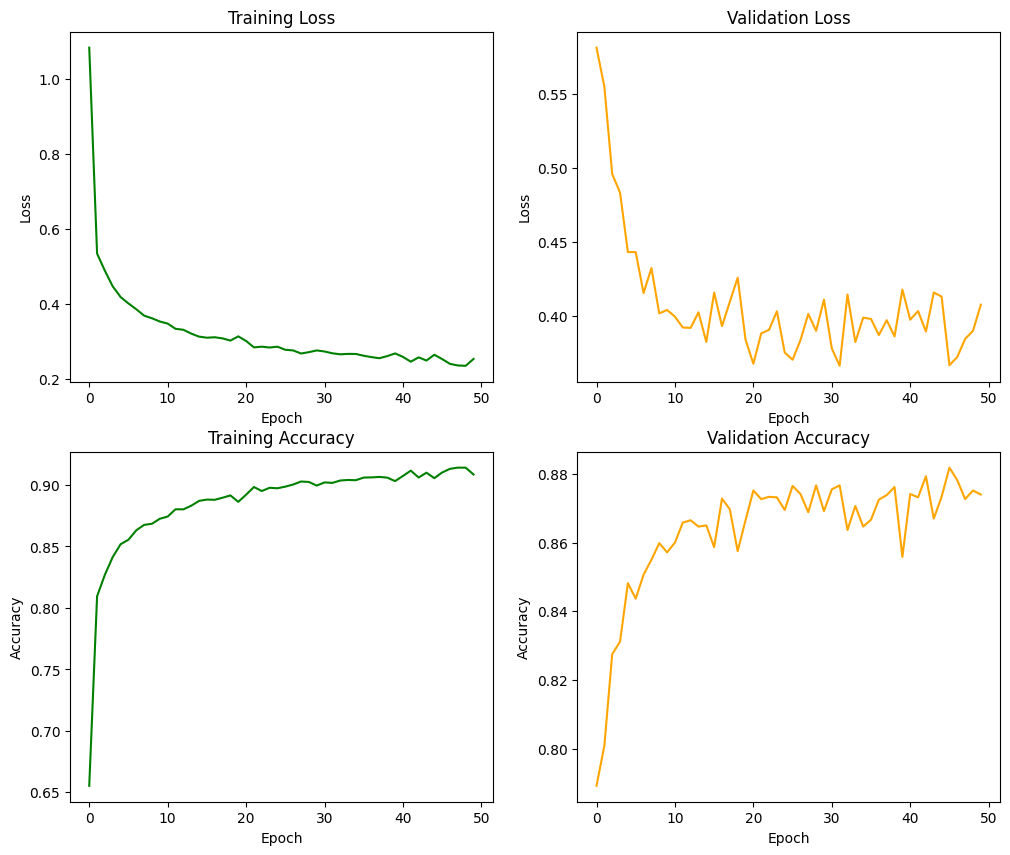

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Batch Normalization

In [ ]:
# Using BatchNorm1d

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 4.7246, Train_Acc: 0.1762, Validation Loss: 3.0690, Val_Acc: 0.2695
EPOCH 2/50, Train_Loss: 2.4515, Train_Acc: 0.3414, Validation Loss: 2.0547, Val_Acc: 0.4035
EPOCH 3/50, Train_Loss: 1.8250, Train_Acc: 0.4555, Validation Loss: 1.6564, Val_Acc: 0.4992
EPOCH 4/50, Train_Loss: 1.5272, Train_Acc: 0.5302, Validation Loss: 1.4327, Val_Acc: 0.5573
EPOCH 5/50, Train_Loss: 1.3517, Train_Acc: 0.5762, Validation Loss: 1.2911, Val_Acc: 0.5910
EPOCH 6/50, Train_Loss: 1.2350, Train_Acc: 0.6085, Validation Loss: 1.1936, Val_Acc: 0.6185
EPOCH 7/50, Train_Loss: 1.1513, Train_Acc: 0.6305, Validation Loss: 1.1215, Val_Acc: 0.6382
EPOCH 8/50, Train_Loss: 1.0901, Train_Acc: 0.6475, Validation Loss: 1.0664, Val_Acc: 0.6540
EPOCH 9/50, Train_Loss: 1.0420, Train_Acc: 0.6595, Validation Loss: 1.0226, Val_Acc: 0.6635
EPOCH 10/50, Train_Loss: 1.0019, Train_Acc: 0.6703, Validation Loss: 0.9866, Val_Acc: 0.6712
EPOCH 11/50, Train_Loss: 0.9697, Train_Acc: 0.6782, Validation Loss: 0.9569, Va

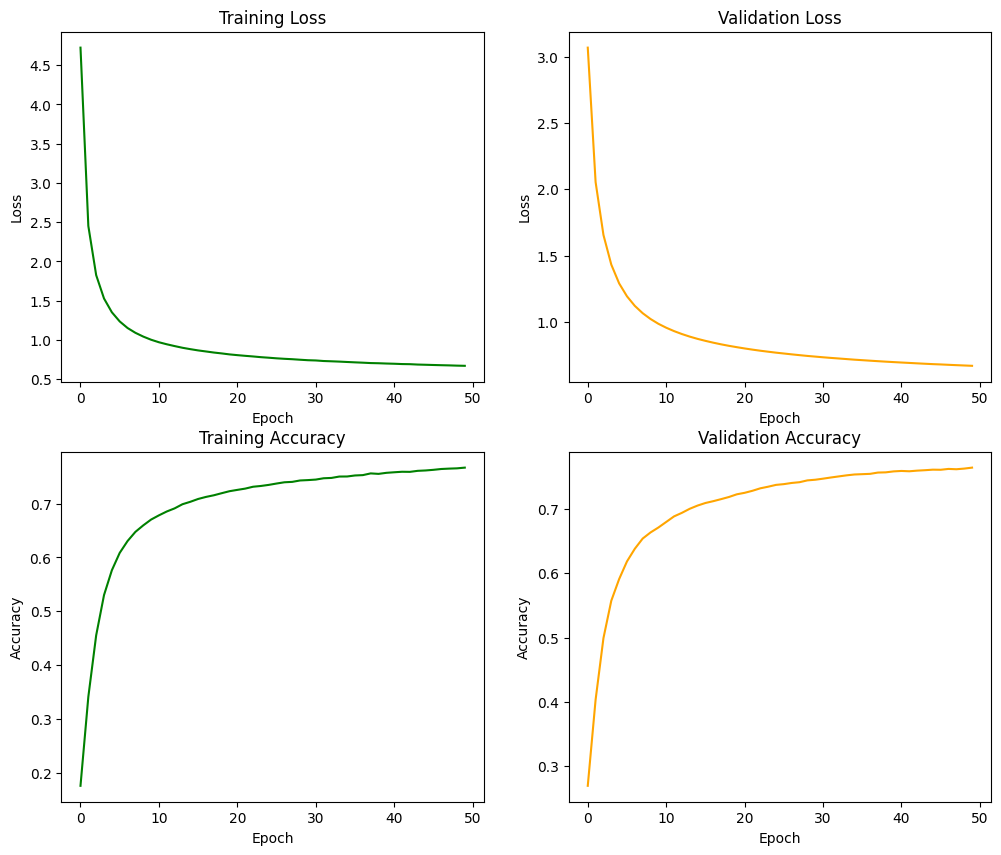

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Skip Connection

In [ ]:
# Using skip connection

# Using BatchNorm1d

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 5.5573, Train_Acc: 0.1606, Validation Loss: 3.0183, Val_Acc: 0.2432
EPOCH 2/50, Train_Loss: 2.5802, Train_Acc: 0.3041, Validation Loss: 2.2377, Val_Acc: 0.3572
EPOCH 3/50, Train_Loss: 2.0277, Train_Acc: 0.3990, Validation Loss: 1.8679, Val_Acc: 0.4278
EPOCH 4/50, Train_Loss: 1.7454, Train_Acc: 0.4548, Validation Loss: 1.6566, Val_Acc: 0.4762
EPOCH 5/50, Train_Loss: 1.5786, Train_Acc: 0.4907, Validation Loss: 1.5262, Val_Acc: 0.5045
EPOCH 6/50, Train_Loss: 1.4676, Train_Acc: 0.5192, Validation Loss: 1.4357, Val_Acc: 0.5240
EPOCH 7/50, Train_Loss: 1.3869, Train_Acc: 0.5401, Validation Loss: 1.3669, Val_Acc: 0.5473
EPOCH 8/50, Train_Loss: 1.3225, Train_Acc: 0.5586, Validation Loss: 1.3104, Val_Acc: 0.5608
EPOCH 9/50, Train_Loss: 1.2707, Train_Acc: 0.5744, Validation Loss: 1.2628, Val_Acc: 0.5753
EPOCH 10/50, Train_Loss: 1.2263, Train_Acc: 0.5878, Validation Loss: 1.2229, Val_Acc: 0.5880
EPOCH 11/50, Train_Loss: 1.1891, Train_Acc: 0.5993, Validation Loss: 1.1869, Va

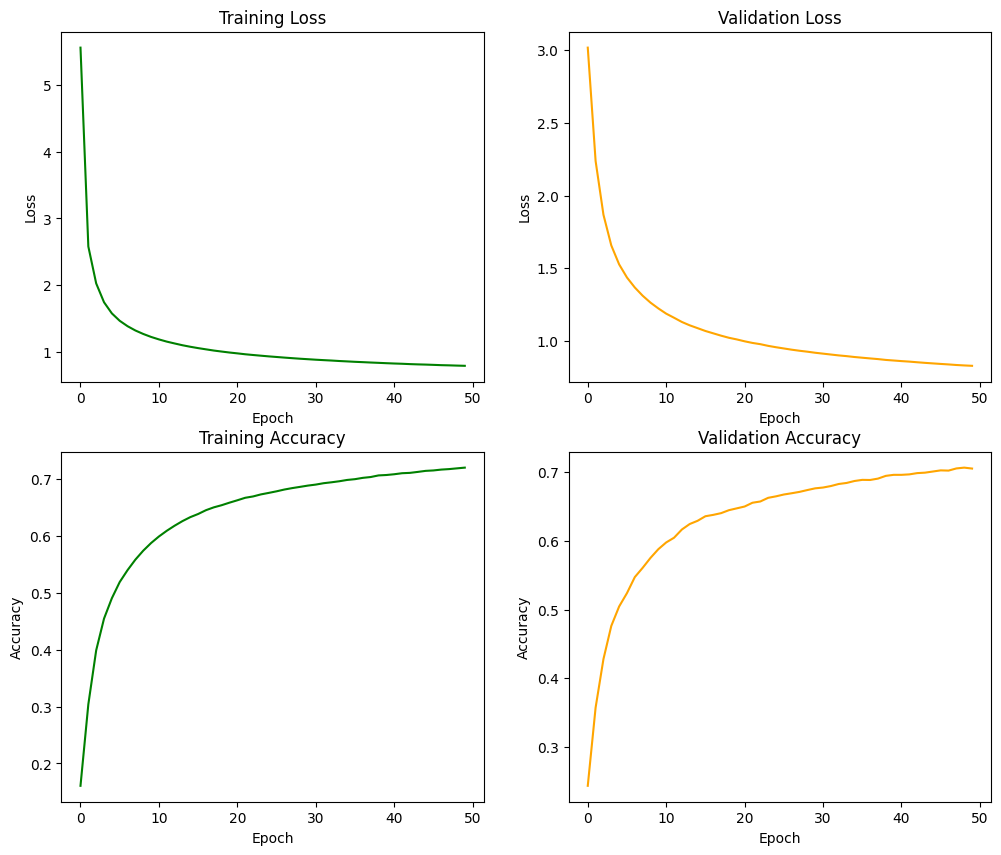

In [ ]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Train layers separately (fine-tuning)

In [5]:
# Build separated models

class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [6]:
# Initialize separated modules

first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

In [7]:
# 1st period: train 1st separation

model = nn. Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# Training 1st separation
epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

In [9]:
# 2nd period: train 2nd separation

for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# Training 2nd separation
epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

In [10]:
# 3rd period: train 3rd separation
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# Training 3rd separation
epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

In [11]:
# 4th period: train 4th separation
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# Training 4th separation
epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 2.2066, Train_Acc: 0.2751, Validation Loss: 2.1295, Val_Acc: 0.3613
EPOCH 2/50, Train_Loss: 2.0491, Train_Acc: 0.4398, Validation Loss: 1.9835, Val_Acc: 0.4657
EPOCH 3/50, Train_Loss: 1.9093, Train_Acc: 0.4964, Validation Loss: 1.8506, Val_Acc: 0.5110
EPOCH 4/50, Train_Loss: 1.7825, Train_Acc: 0.5261, Validation Loss: 1.7319, Val_Acc: 0.5237
EPOCH 5/50, Train_Loss: 1.6701, Train_Acc: 0.5466, Validation Loss: 1.6266, Val_Acc: 0.5428
EPOCH 6/50, Train_Loss: 1.5725, Train_Acc: 0.5593, Validation Loss: 1.5358, Val_Acc: 0.5615
EPOCH 7/50, Train_Loss: 1.4881, Train_Acc: 0.5724, Validation Loss: 1.4573, Val_Acc: 0.5673
EPOCH 8/50, Train_Loss: 1.4167, Train_Acc: 0.5840, Validation Loss: 1.3917, Val_Acc: 0.5732
EPOCH 9/50, Train_Loss: 1.3546, Train_Acc: 0.5920, Validation Loss: 1.3344, Val_Acc: 0.5863
EPOCH 10/50, Train_Loss: 1.3020, Train_Acc: 0.5984, Validation Loss: 1.2860, Val_Acc: 0.5983
EPOCH 11/50, Train_Loss: 1.2563, Train_Acc: 0.6044, Validation Loss: 1.2438, Va

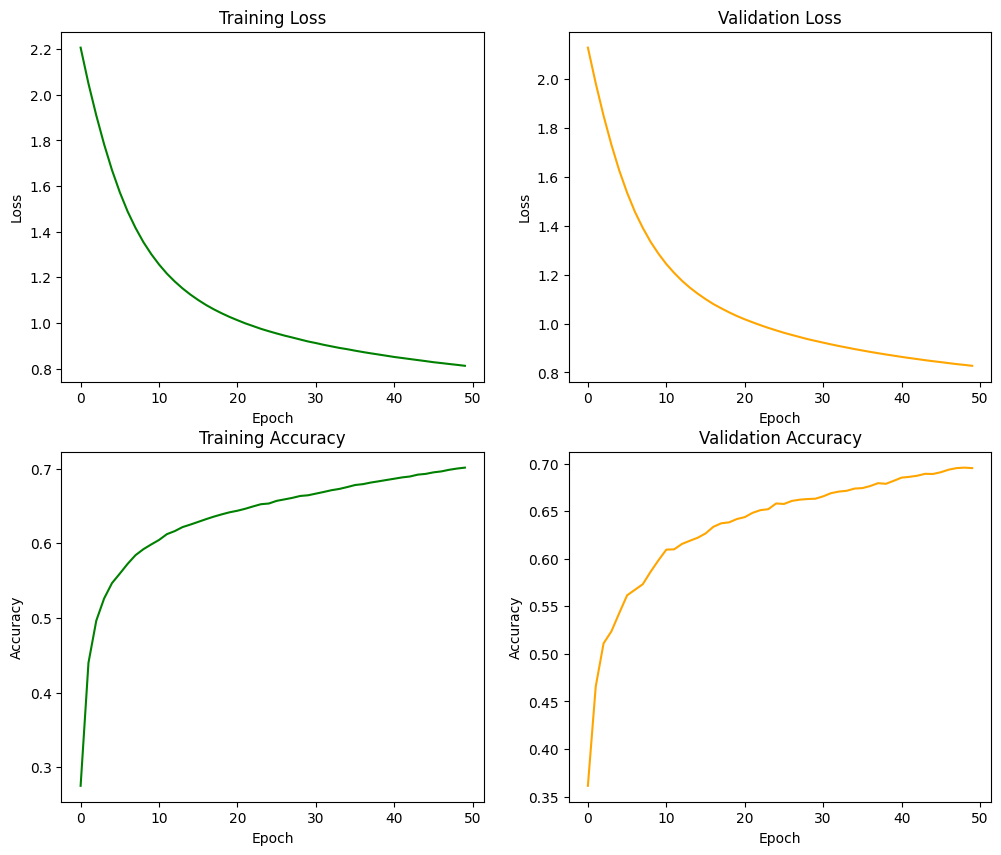

In [12]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Handle Vanishing Gradient by Gradient Normalization

In [21]:
# Custom Gradient Normalization Layer
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: pass input unchanged
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # Normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6) # Avoid division by zero
        return grad_input


# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)


# Build MLP model
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [22]:
# Train model

epochs = 50
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1)==y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1)==y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/50, Train_Loss: 2.0548, Train_Acc: 0.1676, Validation Loss: 1.8611, Val_Acc: 0.1810
EPOCH 2/50, Train_Loss: 1.9809, Train_Acc: 0.1856, Validation Loss: 1.8529, Val_Acc: 0.1828
EPOCH 3/50, Train_Loss: 1.7932, Train_Acc: 0.2238, Validation Loss: 1.7988, Val_Acc: 0.1842
EPOCH 4/50, Train_Loss: 1.7430, Train_Acc: 0.2560, Validation Loss: 1.6521, Val_Acc: 0.2742
EPOCH 5/50, Train_Loss: 1.6383, Train_Acc: 0.2800, Validation Loss: 1.5914, Val_Acc: 0.2703
EPOCH 6/50, Train_Loss: 1.5649, Train_Acc: 0.2881, Validation Loss: 1.5740, Val_Acc: 0.2748
EPOCH 7/50, Train_Loss: 1.5397, Train_Acc: 0.2903, Validation Loss: 1.5443, Val_Acc: 0.2870
EPOCH 8/50, Train_Loss: 1.5238, Train_Acc: 0.2911, Validation Loss: 1.5223, Val_Acc: 0.2948
EPOCH 9/50, Train_Loss: 1.5109, Train_Acc: 0.2911, Validation Loss: 1.5251, Val_Acc: 0.2787
EPOCH 10/50, Train_Loss: 1.5160, Train_Acc: 0.2960, Validation Loss: 1.7841, Val_Acc: 0.2513
EPOCH 11/50, Train_Loss: 1.5725, Train_Acc: 0.2947, Validation Loss: 1.5725, Va

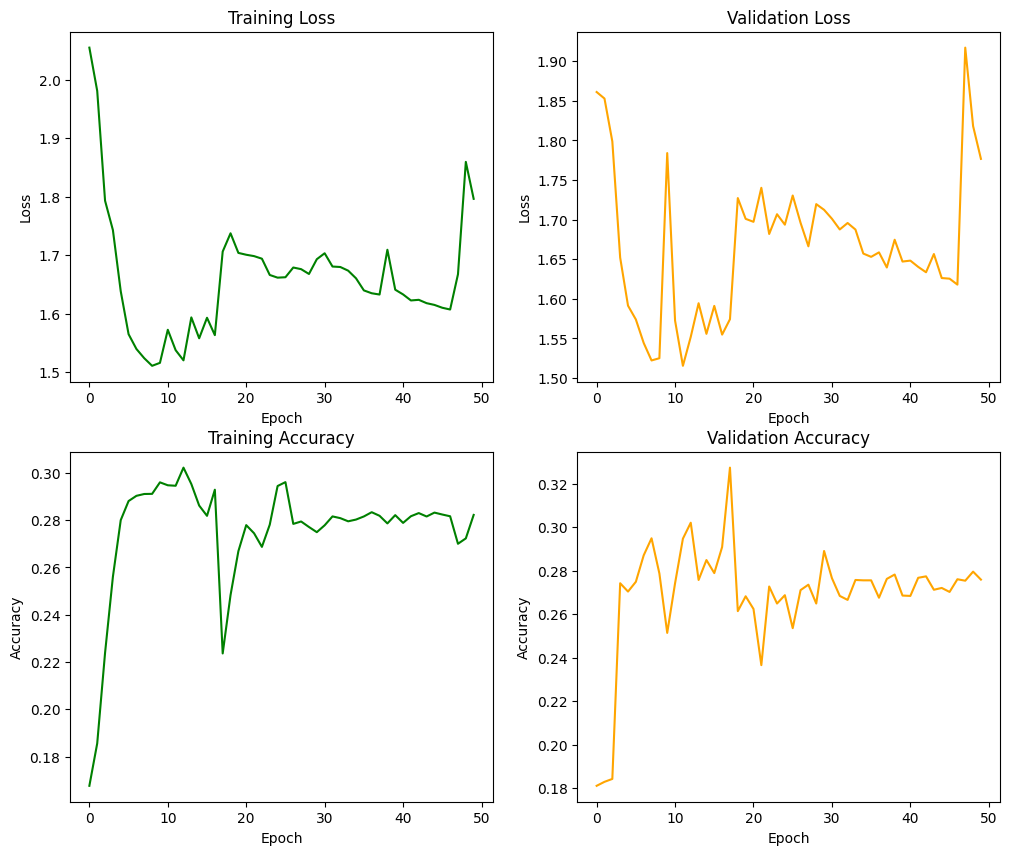

In [23]:
# Visualize performance
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel ='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')

ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()